# 502 Figure 1 and assessment

In [1]:
import pyam
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

<IPython.core.display.Javascript object>

Step 1: Read in the data.

In [2]:
assessment_data = pd.read_excel(
    Path(
        '../data/501_metrics_with_final_cdr.xlsx'
    ),
    index_col=[0,1,2]
)

Step 2: Create a data with the necessary percentiles crunched.

In [3]:
quantiles = [
    0.5,
    0.67,
    0.9
]

In [4]:
quantile_estimates = []
for q in quantiles:
    data_to_append = (
        pd.DataFrame(
            assessment_data
            .groupby(
                level=[
                    'model',
                    'scenario'
                ]
            )['additional_cdr_gtco2_final', '2100_warming']
            .quantile(q=q)
        )
        .rename(
            columns={
                'additional_cdr_gtco2_final':f'p{int(q*100)}',
                '2100_warming':f'p{int(q*100)}_2100_warming'
            }
        )
    )
    quantile_estimates.append(data_to_append)

/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_4402/4053384510.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  assessment_data
/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_4402/4053384510.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  assessment_data
/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_4402/4053384510.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  assessment_data


In [5]:
compiled_quantiles = pd.concat(
    quantile_estimates, 
    axis=1
)

Step 3: Read in the emissions data. We want two things from this:
1. The cumulative (net) CO2 emissions between 2020 and net zero CO2
2. The cumulative (gross) CO2 emissions between net zero CO2 and 2100
3. The yearly rate of change of CH4 emissions between net zero CO2 and 2100 

In [6]:
emissions_data = pyam.IamDataFrame(
    Path(
        '../data/100_scenarios.csv'
    )
)

pyam.core - INFO: Reading file ../data/100_scenarios.csv


In [7]:
emissions_data.load_meta(
    Path(
        '../data/100_meta.xlsx'
    )
)

pyam.core - INFO: Found column 'exclude' in sheet 'meta', moved to attribute `IamDataFrame.exclude`.


In [8]:
emissions_data.swap_time_for_year(
    inplace=True
)

In [9]:
novel_cdr = pyam.IamDataFrame(
    Path(
        '../data/100_novel_cdr.csv'
    )
)

pyam.core - INFO: Reading file ../data/100_novel_cdr.csv


In [10]:
novel_cdr.interpolate(
    time=range(2015, 2101),
    inplace=True
)

In [11]:
compiled_emission_data = pyam.concat(
    [
        emissions_data,
        novel_cdr
    ]
)

Step 4: Filter for the necessary years (2020 - 2100). Then calculate the gross CO2 emissions from fossil fuels and industrial process emissions.

In [12]:
compiled_emission_data.filter(
    year=range(2020, 2101),
    inplace=True
)

In [13]:
compiled_emission_data.add(
    a='AR6 climate diagnostics|Infilled|Emissions|CO2|Energy and Industrial Processes',
    b='Carbon Dioxide Removal|Novel',
    name='AR6 climate diagnostics|Infilled|Emissions|CO2|Energy and Industrial Processes|Gross',
    ignore_units='Mt CO2/yr',
    append=True
)

Step 5: Calculate the cumulative net emissions to net zero.

In [14]:
compiled_emission_data.filter(
    model='GEM*',
    keep=False,
    inplace=True
)

In [15]:
compiled_emission_data.convert_unit(
    current='Mt CO2/yr',
    to='Gt CO2/yr',
    inplace=True
)

In [16]:
compiled_emission_data.require_data(
    variable='AR6 climate diagnostics|Infilled|Emissions|CO2'
)

In [17]:
cum_net_to_netzero = (
    compiled_emission_data
    .filter(variable='AR6 climate diagnostics|Infilled|Emissions|CO2')
    .timeseries()
    .apply(
        lambda x: pyam.timeseries.cumulative(
            x,
            first_year=2020,
            last_year=compiled_emission_data.meta.loc[x.name[0:2], 'netzero|CO2']
        ),
        axis=1
    )
)

In [18]:
compiled_emission_data.set_meta(
    cum_net_to_netzero,
    name='cum_emico2_to_netzero_gtco2'
)

Step 6: Calculate the gross CO2 fossil fuel and industrial emissions from net zero CO2 to 2100.

In [19]:
compiled_emission_data.require_data(
    variable='AR6 climate diagnostics|Infilled|Emissions|CO2|Energy and Industrial Processes|Gross'
)

In [20]:
cum_gross_after_netzero = (
    compiled_emission_data
    .filter(variable='AR6 climate diagnostics|Infilled|Emissions|CO2|Energy and Industrial Processes|Gross')
    .timeseries()
    .apply(
        lambda x: pyam.timeseries.cumulative(
            x,
            first_year=compiled_emission_data.meta.loc[x.name[0:2], 'netzero|CO2'],
            last_year=2100
        ),
        axis=1
    )
)

In [21]:
cum_novel_after_netzero = (
    compiled_emission_data
    .filter(variable='Carbon Dioxide Removal|Novel')
    .timeseries()
    .apply(
        lambda x: pyam.timeseries.cumulative(
            x,
            first_year=compiled_emission_data.meta.loc[x.name[0:2], 'netzero|CO2'],
            last_year=2100
        ),
        axis=1
    )
)

In [22]:
cum_net_co2_after_netzero = (
    compiled_emission_data
    .filter(variable='AR6 climate diagnostics|Infilled|Emissions|CO2')
    .timeseries()
    .apply(
        lambda x: pyam.timeseries.cumulative(
            x,
            first_year=compiled_emission_data.meta.loc[x.name[0:2], 'netzero|CO2'],
            last_year=2100
        ),
        axis=1
    )    
)

In [23]:
compiled_emission_data.set_meta(
    cum_gross_after_netzero,
    name='cum_grossemico2_after_netzero_gtco2'
)

In [24]:
compiled_emission_data.set_meta(
    cum_net_co2_after_netzero,
    name='cum_netemico2_after_netzero_gtco2'
)

In [25]:
compiled_emission_data.set_meta(
    cum_novel_after_netzero,
    name='cum_novel_after_netzero_gtco2'
)

Step 7: Now, calculate the yearly change in the methane (CH4) emissions after global net zero CO2.

In [26]:
change_ch4 = (
    compiled_emission_data
    .filter(variable='AR6 climate diagnostics|Infilled|Emissions|CH4')
    .timeseries()
    .apply(
        lambda x: (
            x[2100] - x[compiled_emission_data.meta.loc[x.name[0:2], 'netzero|CO2']]
        ) / (2100 - compiled_emission_data.meta.loc[x.name[0:2], 'netzero|CO2']),
        axis=1
    )
)

In [27]:
change_ch4_before_netzero = (
    compiled_emission_data
    .filter(variable='AR6 climate diagnostics|Infilled|Emissions|CH4')
    .timeseries()
    .apply(
        lambda x: (
            x[compiled_emission_data.meta.loc[x.name[0:2], 'netzero|CO2']] - x[2020]
        ) / (compiled_emission_data.meta.loc[x.name[0:2], 'netzero|CO2'] - 2020),
        axis=1
    )
)

In [28]:
compiled_emission_data.set_meta(
    change_ch4,
    name='yearly_ch4_change_after_netzero'
)

In [29]:
compiled_emission_data.set_meta(
    change_ch4_before_netzero,
    name='yearly_ch4_change_before_netzero'
)

In [30]:
to_merge = compiled_emission_data.meta[
    [
        'Category_subset',
        #'cum_emico2_to_netzero_gtco2',
        'cum_grossemico2_after_netzero_gtco2',
        'yearly_ch4_change_after_netzero',
        #'yearly_ch4_change_before_netzero', 
        'cum_netemico2_after_netzero_gtco2',
        'cum_novel_after_netzero_gtco2'
    ]
]

Step 8: Append this to the quantile dataframe.

In [31]:
merged_quantile_data = pd.concat(
    [
        compiled_quantiles,
        to_merge
    ],
    axis=1
)

In [32]:
merged_quantile_data

p50  p50_2100_warming       p67  \
model              scenario                                                   
AIM/CGE 2.1        CD-LINKS_NPi2020_400     0.0          1.236271    0.0000   
AIM/CGE 2.2        EN_NPi2020_300f          0.0          1.303397    0.0000   
                   EN_NPi2020_600           0.4          1.478590  192.3165   
AIM/Hub-Global 2.0 1.5C                     0.0          1.251677    0.0000   
C-ROADS-5.005      Ratchet-1.5-limCDR-noOS  0.0          1.117258    0.0000   
...                                         ...               ...       ...   
WITCH 5.0          EN_NPi2020_500f          0.0          1.471612  339.7920   
WITCH-GLOBIOM 3.1  SSP1-19                  0.0          1.264723    0.0000   
                   SSP4-19                  0.0          1.188809    0.0000   
WITCH-GLOBIOM 4.4  CD-LINKS_NPi2020_1000    0.0          1.336467    0.0000   
                   CD-LINKS_NPi2020_400     0.0          1.018260    0.0000   

                                            p67_2100_warming       p90  \
model              scenario                                              
AIM/CGE 2.1        CD-LINKS_NPi2020_400             1.375203   408.827   
AIM/CGE 2.2        EN_NPi2020_300f                  1.428395   456.253   
                   EN_NPi2020_600                   1.615572   857.129   
AIM/Hub-Global 2.0 1.5C                             1.375733   395.764   
C-ROADS-5.005      Ratchet-1.5-limCDR-noOS          1.258132   220.843   
...                                                      ...       ...   
WITCH 5.0          EN_NPi2020_500f                  1.672104  1127.109   
WITCH-GLOBIOM 3.1  SSP1-19                          1.418482   519.020   
                   SSP4-19                          1.307240   236.023   
WITCH-GLOBIOM 4.4  CD-LINKS_NPi2020_1000            1.473968   705.624   
                   CD-LINKS_NPi2020_400             1.123190     0.000   

                                            p90_2100_warming Category_subset  \
model              scenario                                                    
AIM/CGE 2.1        CD-LINKS_NPi2020_400             1.750101      C1a_NZGHGs   
AIM/CGE 2.2        EN_NPi2020_300f                  1.807699      C1a_NZGHGs   
                   EN_NPi2020_600                   2.023190     C1b_+veGHGs   
AIM/Hub-Global 2.0 1.5C                             1.742176      C1a_NZGHGs   
C-ROADS-5.005      Ratchet-1.5-limCDR-noOS          1.627219      C1a_NZGHGs   
...                                                      ...             ...   
WITCH 5.0          EN_NPi2020_500f                  2.162365      C1a_NZGHGs   
WITCH-GLOBIOM 3.1  SSP1-19                          1.800749      C1a_NZGHGs   
                   SSP4-19                          1.646548      C1a_NZGHGs   
WITCH-GLOBIOM 4.4  CD-LINKS_NPi2020_1000            1.892603      C1a_NZGHGs   
                   CD-LINKS_NPi2020_400             1.431761      C1a_NZGHGs   

                                            cum_grossemico2_after_netzero_gtco2  \
model              scenario                                                       
AIM/CGE 2.1        CD-LINKS_NPi2020_400                              278.722779   
AIM/CGE 2.2        EN_NPi2020_300f                                   336.951137   
                   EN_NPi2020_600                                    531.936710   
AIM/Hub-Global 2.0 1.5C                                              224.653681   
C-ROADS-5.005      Ratchet-1.5-limCDR-noOS                            47.842713   
...                                                                         ...   
WITCH 5.0          EN_NPi2020_500f                                   298.080554   
WITCH-GLOBIOM 3.1  SSP1-19                                           362.106991   
                   SSP4-19                                           367.774696   
WITCH-GLOBIOM 4.4  CD-LINKS_NPi2020_1000                             192.111292   
                

Step 1: Let us first scatter the additional CDR against the 2100 warming.

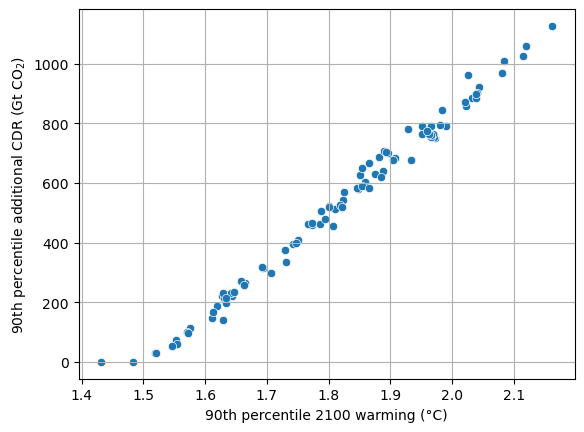

In [33]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=merged_quantile_data,
    x='p90_2100_warming',
    y='p90',
    ax=ax
)
ax.set_xlabel('90th percentile 2100 warming (°C)')
ax.set_ylabel('90th percentile additional CDR (Gt CO$_2$)')
ax.grid()

Step 2: What causes the 2100 warming?

<Axes: xlabel='p90_2100_warming', ylabel='cum_netemico2_after_netzero_gtco2'>

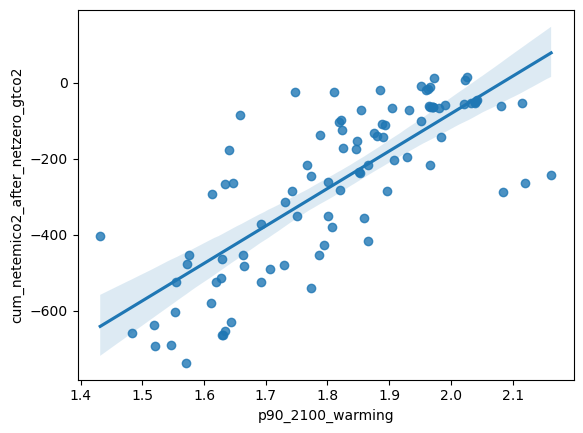

In [34]:
sns.regplot(
    data=merged_quantile_data,
    x='p90_2100_warming',
    y='cum_netemico2_after_netzero_gtco2',
)

<Axes: xlabel='p90_2100_warming', ylabel='yearly_ch4_change_after_netzero'>

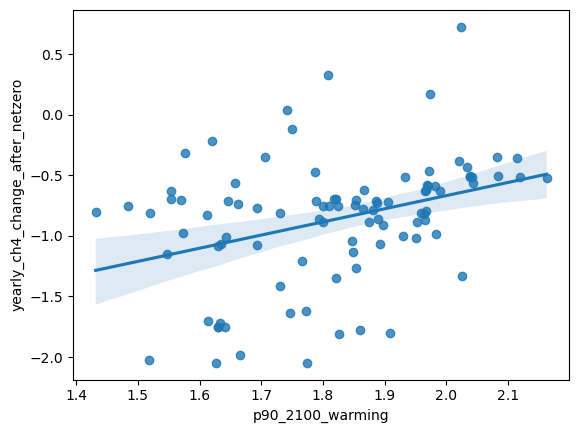

In [35]:
sns.regplot(
    data=merged_quantile_data,
    x='p90_2100_warming',
    y='yearly_ch4_change_after_netzero',
)

<Axes: xlabel='cum_novel_after_netzero_gtco2', ylabel='p90'>

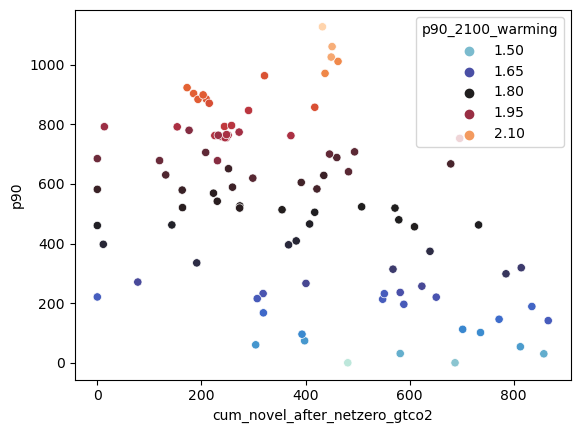

In [36]:
sns.scatterplot(
    y='p90',
    x='cum_novel_after_netzero_gtco2',
    data=merged_quantile_data,
    hue='p90_2100_warming',
    palette='icefire'
)

<Axes: xlabel='yearly_ch4_change_after_netzero', ylabel='p90'>

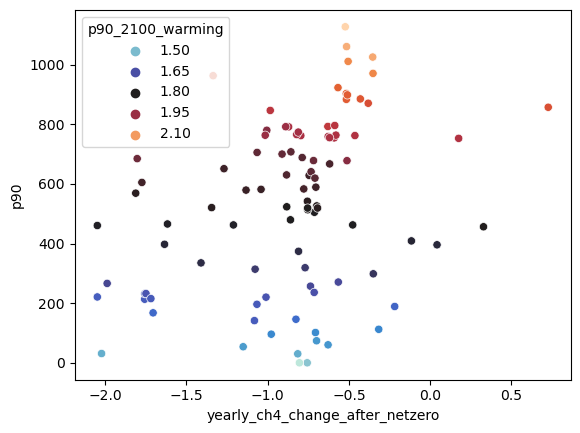

In [37]:
sns.scatterplot(
    y='p90',
    x='yearly_ch4_change_after_netzero',
    data=merged_quantile_data,
    hue='p90_2100_warming',
    palette='icefire'
)

<Axes: xlabel='cum_netemico2_after_netzero_gtco2', ylabel='p90_2100_warming'>

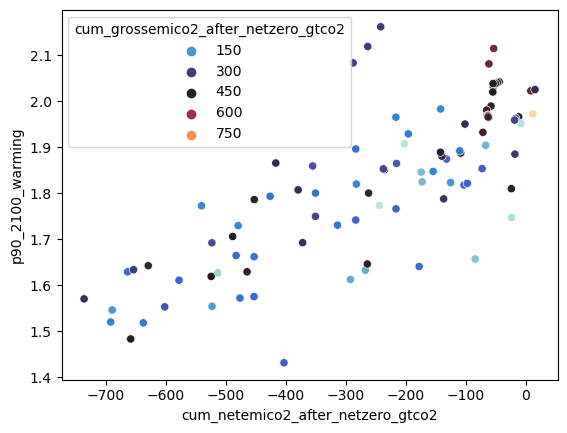

In [38]:
sns.scatterplot(
    x='cum_netemico2_after_netzero_gtco2',
    y='p90_2100_warming',
    data=merged_quantile_data,
    hue='cum_grossemico2_after_netzero_gtco2',palette='icefire'
)

In [39]:
res = smf.ols(
    formula = 'p90 ~ p90_2100_warming + yearly_ch4_change_after_netzero' ,
    data = merged_quantile_data
)

In [40]:
coeff = res.fit()

In [41]:
coeff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    p90   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     4632.
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           4.60e-93
Time:                        12:04:24   Log-Likelihood:                -452.27
No. Observations:                  95   AIC:                             910.5
Df Residuals:                      92   BIC:                             918.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                       -2598.1546     36.630    -70.931      0.000   -2670.904   -2525.405
p90_2100_warming                 1713.9999     18.859     90.887      0.000    1676.545    1751.455
yearly_ch4_change_after_netzero   -15.3470      6.139     -2.500      0.014     -27.540      -3.154
==============================================================================
Omnibus:                       35.572   Durbin-Watson:                   1.559
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.750
Skew:                           1.305   Prob(JB):                     4.39e-21
Kurtosis:                       7.108   Cond. No.                         31.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
import statsmodels.api as sm

In [43]:
merged_quantile_data

p50  p50_2100_warming       p67  \
model              scenario                                                   
AIM/CGE 2.1        CD-LINKS_NPi2020_400     0.0          1.236271    0.0000   
AIM/CGE 2.2        EN_NPi2020_300f          0.0          1.303397    0.0000   
                   EN_NPi2020_600           0.4          1.478590  192.3165   
AIM/Hub-Global 2.0 1.5C                     0.0          1.251677    0.0000   
C-ROADS-5.005      Ratchet-1.5-limCDR-noOS  0.0          1.117258    0.0000   
...                                         ...               ...       ...   
WITCH 5.0          EN_NPi2020_500f          0.0          1.471612  339.7920   
WITCH-GLOBIOM 3.1  SSP1-19                  0.0          1.264723    0.0000   
                   SSP4-19                  0.0          1.188809    0.0000   
WITCH-GLOBIOM 4.4  CD-LINKS_NPi2020_1000    0.0          1.336467    0.0000   
                   CD-LINKS_NPi2020_400     0.0          1.018260    0.0000   

                                            p67_2100_warming       p90  \
model              scenario                                              
AIM/CGE 2.1        CD-LINKS_NPi2020_400             1.375203   408.827   
AIM/CGE 2.2        EN_NPi2020_300f                  1.428395   456.253   
                   EN_NPi2020_600                   1.615572   857.129   
AIM/Hub-Global 2.0 1.5C                             1.375733   395.764   
C-ROADS-5.005      Ratchet-1.5-limCDR-noOS          1.258132   220.843   
...                                                      ...       ...   
WITCH 5.0          EN_NPi2020_500f                  1.672104  1127.109   
WITCH-GLOBIOM 3.1  SSP1-19                          1.418482   519.020   
                   SSP4-19                          1.307240   236.023   
WITCH-GLOBIOM 4.4  CD-LINKS_NPi2020_1000            1.473968   705.624   
                   CD-LINKS_NPi2020_400             1.123190     0.000   

                                            p90_2100_warming Category_subset  \
model              scenario                                                    
AIM/CGE 2.1        CD-LINKS_NPi2020_400             1.750101      C1a_NZGHGs   
AIM/CGE 2.2        EN_NPi2020_300f                  1.807699      C1a_NZGHGs   
                   EN_NPi2020_600                   2.023190     C1b_+veGHGs   
AIM/Hub-Global 2.0 1.5C                             1.742176      C1a_NZGHGs   
C-ROADS-5.005      Ratchet-1.5-limCDR-noOS          1.627219      C1a_NZGHGs   
...                                                      ...             ...   
WITCH 5.0          EN_NPi2020_500f                  2.162365      C1a_NZGHGs   
WITCH-GLOBIOM 3.1  SSP1-19                          1.800749      C1a_NZGHGs   
                   SSP4-19                          1.646548      C1a_NZGHGs   
WITCH-GLOBIOM 4.4  CD-LINKS_NPi2020_1000            1.892603      C1a_NZGHGs   
                   CD-LINKS_NPi2020_400             1.431761      C1a_NZGHGs   

                                            cum_grossemico2_after_netzero_gtco2  \
model              scenario                                                       
AIM/CGE 2.1        CD-LINKS_NPi2020_400                              278.722779   
AIM/CGE 2.2        EN_NPi2020_300f                                   336.951137   
                   EN_NPi2020_600                                    531.936710   
AIM/Hub-Global 2.0 1.5C                                              224.653681   
C-ROADS-5.005      Ratchet-1.5-limCDR-noOS                            47.842713   
...                                                                         ...   
WITCH 5.0          EN_NPi2020_500f                                   298.080554   
WITCH-GLOBIOM 3.1  SSP1-19                                           362.106991   
                   SSP4-19                                           367.774696   
WITCH-GLOBIOM 4.4  CD-LINKS_NPi2020_1000                             192.111292   
                

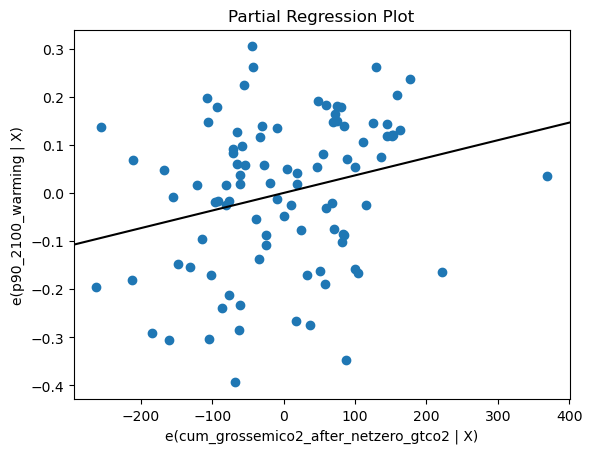

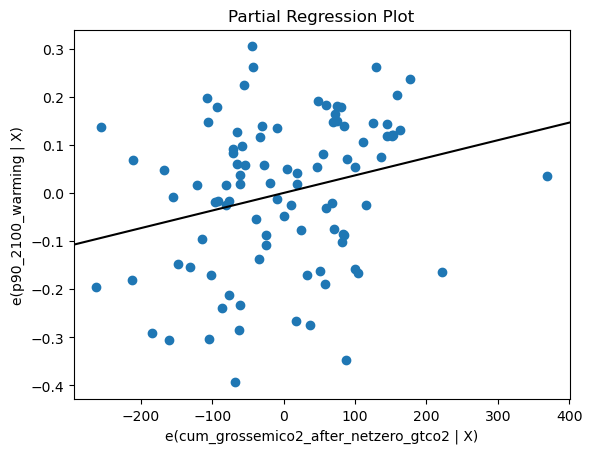

In [44]:
sm.graphics.plot_partregress("p90_2100_warming", "cum_grossemico2_after_netzero_gtco2", ['yearly_ch4_change_after_netzero'], data=merged_quantile_data.dropna(), obs_labels=False)

In [45]:
merged_quantile_data.to_excel(
    '../data/502_allC1.xlsx', 
    merge_cells=False
)